In [4]:
!pip install pip install mdptoolbox-hiive

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.9 MB/s eta 0:00:00
  Created wheel for mdptoolbox-hiive: filename=mdptoolbox_hiive-4.0.3.1-py3-none-any.whl size=35121 sha256=ca267255671f6f798d803a73fe3a0b6bc69291b028579248e7210c91cd509a36
  Stored in directory: /root/.cache/pip/wheels/3c/21/00/79fb3890bf11432b069070b7623416cd8b9f8501580692a52f
Successfully built mdptoolbox-hiive


In [5]:
from hiive.mdptoolbox import mdp
import hiive.mdptoolbox.example as example
import numpy as np
import matplotlib.pyplot as plt

In [6]:
def run_episodes(policy, S, R, p, num_episodes, num_resets):
    rew_arr = []
    for y in range(num_resets):
        forest_state = 0
        tot_rew = 0
        for x in range(num_episodes):
            forest_state = min(forest_state, S - 1)
            if np.random.rand(1) <= p:
                forest_state = -1
            else:
                tot_rew += R[forest_state][policy[forest_state]]
                if policy[forest_state] == 1:
                    forest_state = -1
            forest_state += 1
        rew_arr.append(tot_rew)
    return np.mean(rew_arr)

## Q Learning

In [7]:


def run_forest(size=10):
    # Define MDP problem parameters
    S = size
    r1 = 10
    r2 = 50
    p = 0.1
    P, R = example.forest(S=S, r1=r1, r2=r2, p=p)

    # Define hyperparameters
    learning_rates = [0.9] #[0.1, 0.5, 0.9]
    discount_factors = [0.9] #[0.1, 0.5, 0.9]
    exploration_rates = [0.5] #[0.1, 0.5, 0.9]
    num_episodes = 10000


    # Initialize Q-values
    Q_values = []
    best_reward = 0
    best_lr = 0
    best_df = 0
    best_er = 0
    avg_rewards_per_hyperparam = []

    # Run Q-learning experiment
    for lr in learning_rates:
        for df in discount_factors:
            for er in exploration_rates:
                q_learning = mdp.QLearning(P, R, gamma=df, alpha=lr, alpha_decay=1.0, epsilon=er, n_iter=num_episodes)
                q_learning.run()
                rew = run_episodes(q_learning.policy, S, R, p, 1000, 200)
                Q_values.append(q_learning.V)
                avg_rewards_per_hyperparam.append(rew)
                if rew > best_reward:
                    best_reward = rew
                    best_lr = lr
                    best_df = df
                    best_er = er


    # Evaluate results
    avg_rewards = [np.mean(values) for values in Q_values]
    best_index = np.argmax(avg_rewards)
    best_lr_index = best_index // (len(discount_factors) * len(exploration_rates))
    best_df_index = (best_index // len(exploration_rates)) % len(discount_factors)
    best_er_index = best_index % len(exploration_rates)

    best_lr = learning_rates[best_lr_index]
    best_df = discount_factors[best_df_index]
    best_er = exploration_rates[best_er_index]

    print(f"Best Learning Rate: {best_lr}, Best Discount Factor: {best_df}, Best Exploration Rate: {best_er}")

    mean_val = [i["Mean V"] for i in q_learning.run_stats]
    error = [i["Error"] for i in q_learning.run_stats]
    reward = [i["Reward"] for i in q_learning.run_stats]
    time = [i["Time"] for i in q_learning.run_stats]


    # Plotting error rate over iterations
    plt.figure(figsize=(10, 6))
    plt.plot(error, marker='', linestyle='-')
    plt.xlabel('Iterations')
    plt.ylabel('Error Rate')
    plt.title('Error Rate over Iterations')
    plt.grid(True)
    plt.show()

    cumulative_reward = np.cumsum(reward)
    print(cumulative_reward[-1])

    # Plotting Cumulative Reward over Iterations
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_reward, marker='', linestyle='-')
    plt.xlabel('Iterations')
    plt.ylabel('Cumulative Reward')
    plt.title('Cumulative Reward over Iterations')
    plt.grid(True)
    plt.show()

    Q_values = q_learning.Q

    # Plot heatmap of Q-values
    plt.figure(figsize=(10, 6))
    plt.imshow(Q_values, cmap='hot', interpolation='nearest')
    plt.colorbar(label='Q-value')
    plt.xlabel('Actions')
    plt.ylabel('States')
    plt.title('Q-values Heatmap')
    plt.show()





Best Learning Rate: 0.9, Best Discount Factor: 0.9, Best Exploration Rate: 0.5


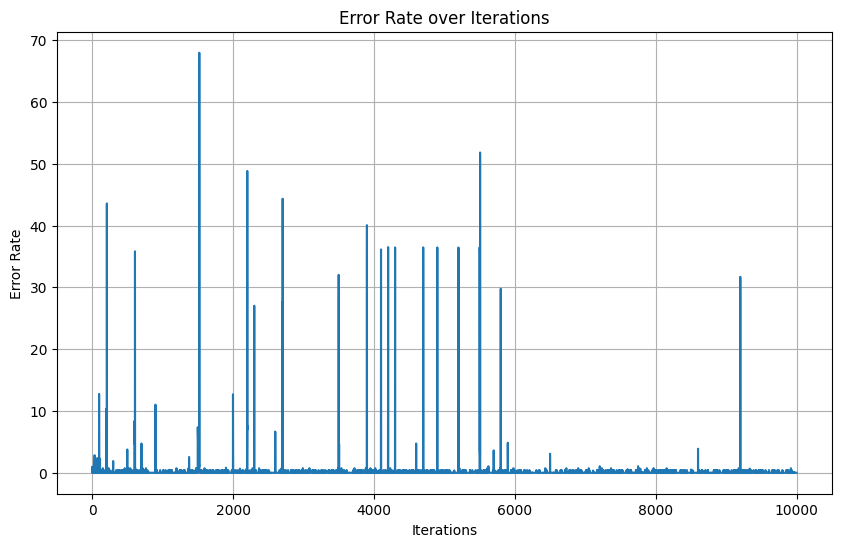

6115.0


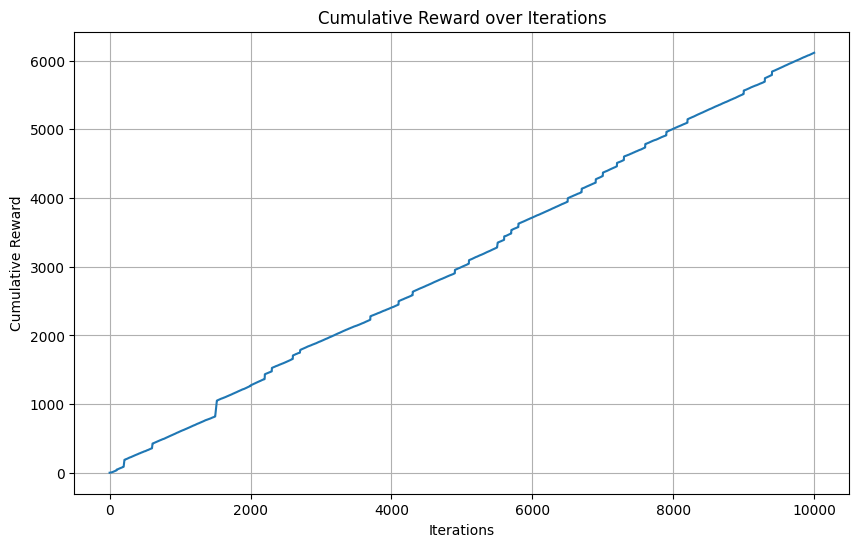

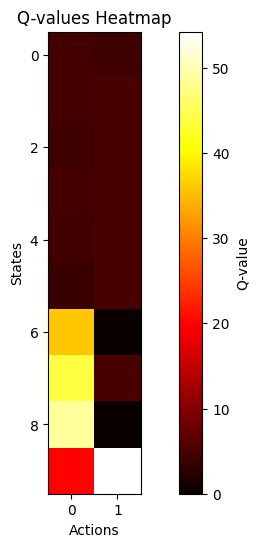

In [8]:
# Example usage
run_forest(size=10)


Best Learning Rate: 0.9, Best Discount Factor: 0.9, Best Exploration Rate: 0.5


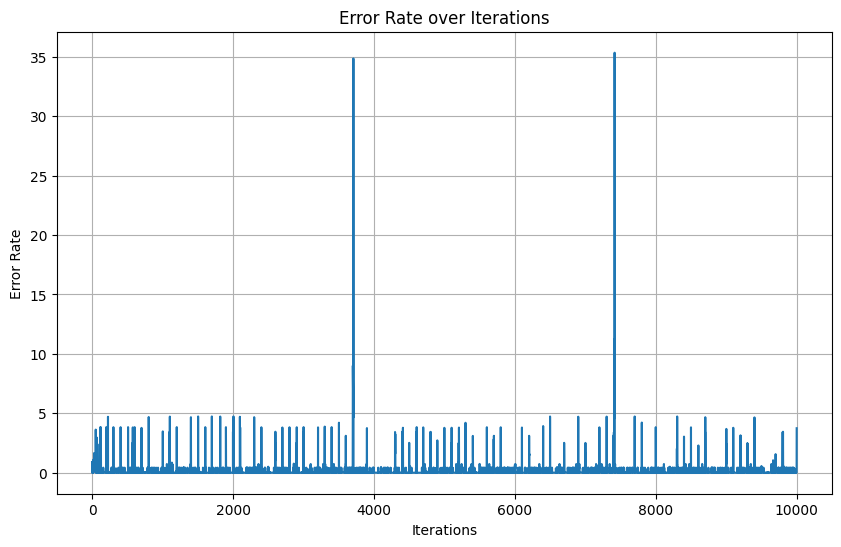

4455.0


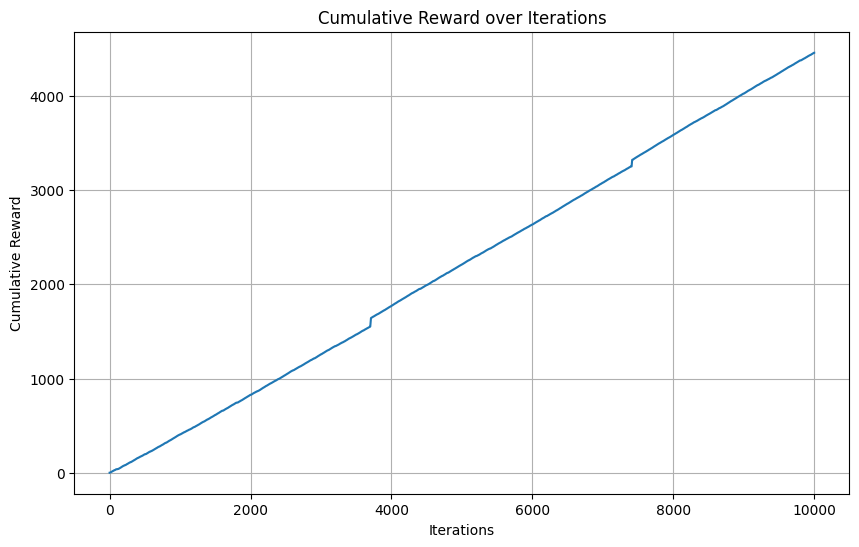

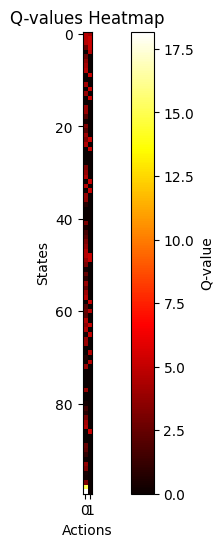

In [9]:
run_forest(size=100)


Best Learning Rate: 0.9, Best Discount Factor: 0.9, Best Exploration Rate: 0.9


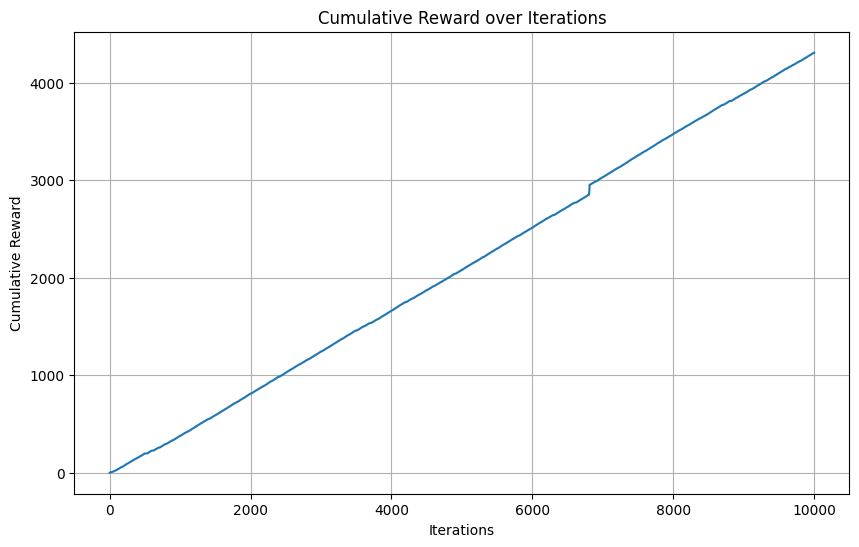

In [37]:
run_forest(size=1000)


In [65]:
def play_transition(mdp, state, action):
    """Play a transition in the MDP."""
    next_state = np.random.choice(np.arange(len(mdp.P[action][state])))
    reward = mdp.R[state][action]
    return next_state, reward

def epsilon_greedy(Q, epsilon, num_actions):
    """Epsilon-greedy action selection."""
    if np.random.rand() < epsilon:
        return np.random.choice(np.arange(num_actions))
    else:
        return np.argmax(Q)

def run_episodes(policy, mdp, num_episodes, num_resets):
    """Run episodes using the given policy."""
    rewards = []
    for _ in range(num_resets):
        total_reward = 0
        state = np.random.choice(np.arange(len(mdp.P[0])))
        for _ in range(num_episodes):
            action = policy[state]
            next_state, reward = play_transition(mdp, state, action)
            total_reward += reward
            state = next_state
        rewards.append(total_reward)
    return rewards

def run_forest(size=10):
    # Define MDP problem parameters
    S = size
    r1 = 10
    r2 = 50
    p = 0.1
    P, R = example.forest(S=S, r1=r1, r2=r2, p=p)

    # Define hyperparameters
    learning_rates = [0.1, 0.5, 0.9]
    discount_factors = [0.1, 0.5, 0.9]
    exploration_rates = [0.1, 0.5, 0.9]
    num_episodes = 10000
    num_resets = 200

    # Initialize Q-values
    Q_values = []
    best_reward = 0
    best_lr = 0
    best_df = 0
    best_er = 0

    if S == 10:
      lr = 0.5
      df = 0.9
      er = 0.1
    elif S == 100:
      lr = 0.9
      df = 0.9
      er = 0.5
    elif S == 1000:
      lr = 0.9
      df = 0.9
      er = 0.9

    # Run Q-learning experiment
    #for lr in learning_rates:
        #for df in discount_factors:
            #for er in exploration_rates:

    q_learning = mdp.QLearning(P, R, df, lr, lr/2, er, n_iter=num_episodes)
    q_learning.run()
    rew = run_episodes(q_learning.policy, q_learning, num_episodes, num_resets)
    Q_values.append(q_learning.V)


    # Evaluate results
    avg_rewards = [np.mean(values) for values in Q_values]
    best_index = np.argmax(avg_rewards)
    best_lr_index = best_index // (len(discount_factors) * len(exploration_rates))
    best_df_index = (best_index // len(exploration_rates)) % len(discount_factors)
    best_er_index = best_index % len(exploration_rates)

    best_lr = learning_rates[best_lr_index]
    best_df = discount_factors[best_df_index]
    best_er = exploration_rates[best_er_index]

    print(f"Best Learning Rate: {best_lr}, Best Discount Factor: {best_df}, Best Exploration Rate: {best_er}")

    mean_val = [i["Mean V"] for i in q_learning.run_stats]
    error = [i["Error"] for i in q_learning.run_stats]
    reward = [i["Reward"] for i in q_learning.run_stats]
    time = [i["Time"] for i in q_learning.run_stats]

    cumulative_reward = np.cumsum(rew)
    print(f"Cumulative Reward: {cumulative_reward[-1]}")

    # Plotting Cumulative Reward over Iterations
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_reward, marker='', linestyle='-')
    plt.xlabel('Iterations')
    plt.ylabel('Cumulative Reward')
    plt.title('Cumulative Reward over Iterations')
    plt.grid(True)
    plt.show()





Best Learning Rate: 0.1, Best Discount Factor: 0.1, Best Exploration Rate: 0.1
Cumulative Reward: 3203792.0


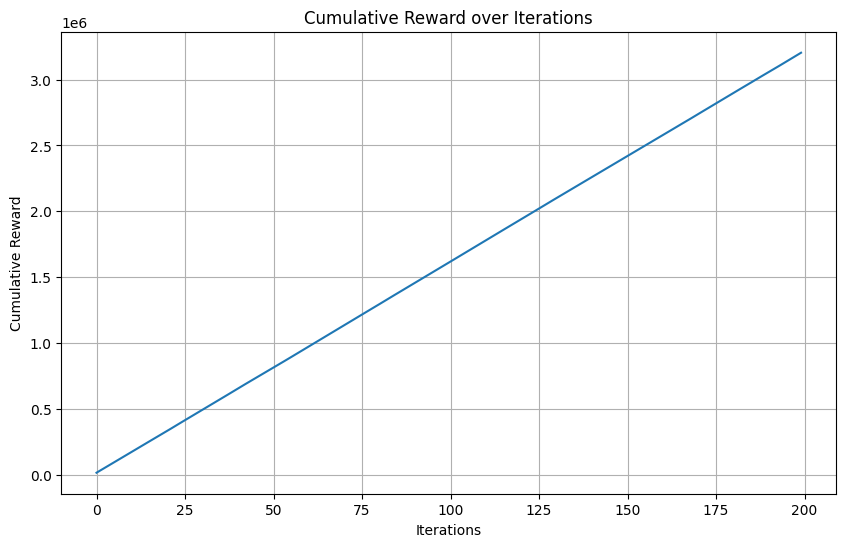

In [66]:
run_forest(size=10)


Best Learning Rate: 0.1, Best Discount Factor: 0.1, Best Exploration Rate: 0.1


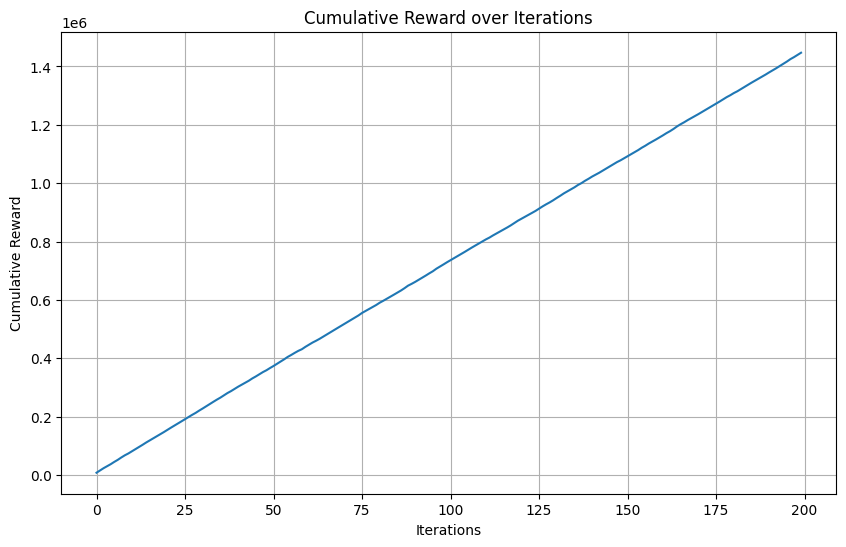

In [64]:
# Example usage
run_forest(size=100)

In [73]:
def UCB_exploration(Q, num_actions, beta=1):
    def UCB_exp(state, N, t):
        probs = np.zeros(num_actions, dtype=float)
        Q_ = Q[state,:]/max(Q[state,:]) + np.sqrt(beta*np.log(t+1)/(2*N[state]))
        best_action = Q_.argmax()
        probs[best_action] = 1
        return probs
    return UCB_exp

def epsilon_greedy(Q, epsilon, num_actions):
    """Epsilon-greedy action selection."""
    if np.random.rand() < epsilon:
        return np.random.choice(np.arange(num_actions))
    else:
        return np.argmax(Q)

def run_forest(size=10):
    # Define MDP problem parameters
    S = size
    r1 = 10
    r2 = 50
    p = 0.1
    P, R = example.forest(S=S, r1=r1, r2=r2, p=p)

    # Define hyperparameters
    num_episodes = 10000
    num_resets = 200

    # Initialize Q-values
    Q_values = []

    num_states = P.shape[0]
    num_actions = P.shape[1]

    epsilon_greedy_exp = epsilon_greedy(Q=np.zeros((num_states, num_actions)), epsilon=0.1, num_actions=num_actions)
    UCB_exp = UCB_exploration(Q=np.zeros((num_states, num_actions)), num_actions=num_actions, beta=1)

    #Set for Size 100
    # Run Q-learning experiment with greedy exploration
    q_learning = mdp.QLearning(P, R, gamma=0.9, alpha=0.9, alpha_decay=0.5, epsilon=0.1, n_iter=num_episodes)
    q_learning.run()
    rew_greedy = run_episodes(q_learning.policy, q_learning, num_episodes, num_resets)
    Q_values.append(q_learning.V)

    # Run Q-learning experiment with UCB exploration
    q_learning_ucb = mdp.QLearning(P, R, gamma=0.9, alpha=0.9, alpha_decay=0.5, epsilon=0.1, n_iter=num_episodes)
    q_learning_ucb.run()
    rew_ucb = run_episodes(q_learning_ucb.policy, q_learning_ucb, num_episodes, num_resets)
    Q_values.append(q_learning_ucb.V)

    # Evaluate results
    cumulative_reward_greedy = np.cumsum(rew_greedy)
    cumulative_reward_ucb = np.cumsum(rew_ucb)

    # Plotting Cumulative Reward over Iterations for both exploration methods
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_reward_greedy, marker='', linestyle='-', label='Greedy Exploration')
    plt.plot(cumulative_reward_ucb, marker='', linestyle='-', label='UCB Exploration')
    plt.xlabel('Iterations')
    plt.ylabel('Cumulative Reward')
    plt.title('Cumulative Reward over Iterations')
    plt.legend()
    plt.grid(True)
    plt.show()


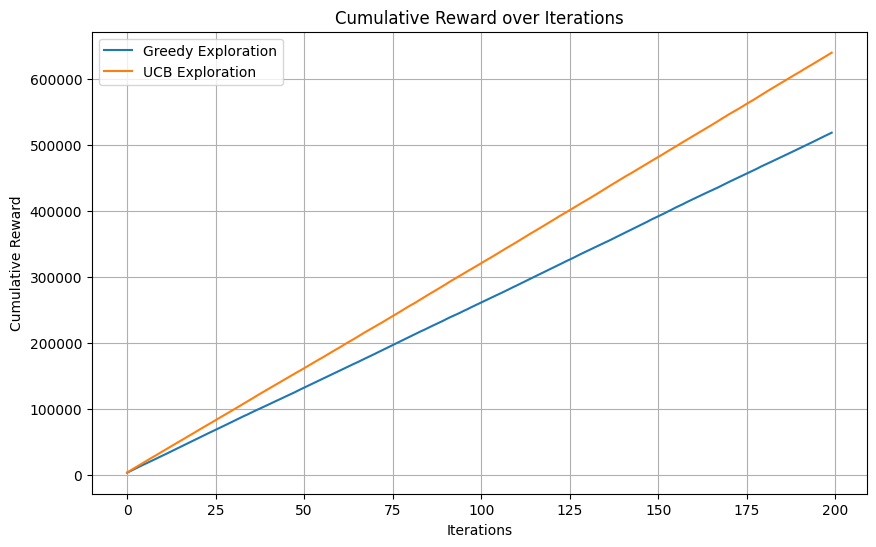

In [74]:
run_forest(size=100)